# Introduction
In my [previous blog post](https://www.feststelltaste.de/spotting-co-changing-files/), we've seen how we can identify files that change together in one commit.

In this blog post, we take the analysis to an advanced level:

* We first refine the definition of "belongs together"
* We're using a more fine-grained model for determine the similarity of conjoint changes
* We're creating a visualization that let us determine the underlying architecture of a software system base on the conjoint changes

We're using Python and pandas as well as some algorithms from scikit-learn for these purposes.

# Data

For this analysis, we use a former project of me and some buddys of mine. It's called "DropOver", a web application that can manage events with features like event sites, schedulings, comments, file uploads and so on. Albeit I can't share the repository yet, you have to know that we developed the software almost strictly feature-based by feature teams (ok, one developer was one team). The history of this repository should perfectly fit for validating our use case for grouping co-changing sourcecode because an identified group should represent a feature.

We use a little helper library for the data import of the project.

In [70]:
from lib.ozapfdis.git_tc import log_numstat

#Autoren
GIT_REPO_DIR = "../../dropover_git/"
# Domänen
#GIT_REPO_DIR = "../../buschmais-spring-petclinic/" 
#Sprachen
#GIT_REPO_DIR = "../../fossology_fork/"
#allgemein
#GIT_REPO_DIR = "../../synthetic_repo/"

git_log = log_numstat(GIT_REPO_DIR)[['sha', 'timestamp', 'author', 'file']]
git_log.head()

,sha,timestamp,author,file
1,8c686954,2016-07-22 17:43:38,Michael,backend/pom-2016-07-16_04-40-56-752.xml
4,97c6ef96,2016-07-16 09:51:15,Markus,backend/src/test/java/at/dropover/scheduling/i...
6,3f7cf92c,2016-07-16 09:07:31,Markus,backend/src/main/webapp/app/widgets/gallery/js...
7,3f7cf92c,2016-07-16 09:07:31,Markus,backend/src/main/webapp/app/widgets/gallery/vi...
9,ec85fe73,2016-07-16 08:12:29,Chris,backend/src/main/java/at/dropover/files/intera...


In [71]:
git_log = git_log[git_log.file.str.endswith(".java")]
git_log = git_log[~git_log.file.str.endswith("Test.java")]
git_log.head()

,sha,timestamp,author,file
9,ec85fe73,2016-07-16 08:12:29,Chris,backend/src/main/java/at/dropover/files/intera...
5053,bfea33b8,2016-07-16 02:02:02,Markus,backend/src/main/java/at/dropover/scheduling/i...
5066,ab9ad48e,2016-07-16 00:50:20,Chris,backend/src/main/java/at/dropover/scheduling/i...
5070,0732e9cb,2016-07-16 00:27:20,Chris,backend/src/main/java/at/dropover/files/intera...
5071,0732e9cb,2016-07-16 00:27:20,Chris,backend/src/test/java/at/dropover/files/FileTe...


# Analysis

## Refine conjoint commits
Alright, let's begin with wrangling the data that commits reflect more the commit behaviour in the project at hand. There are many fine-granular commits in the code base

In [72]:
git_log.author.value_counts()

Chris      786
Markus     270
Michael    207
Name: author, dtype: int64

If we look a

In [73]:
commits_per_author = git_log.groupby('author').sha.nunique()
files_changed_per_authors = git_log.groupby('author').file.count()
commits_per_author / files_changed_per_authors

author
Chris      0.171756
Markus     0.170370
Michael    0.231884
dtype: float64

In [74]:
import pandas as pd
#commits_per_day = git_log.groupby([pd.Grouper(key='timestamp', freq='1D'), 'file']).first()
commits_per_day = git_log.groupby(['timestamp', 'file']).first()
commits_per_day.head()

sha  \
timestamp           file                                                           
2013-02-04 18:23:00 backend/src/main/java/at/dropover/package-info....  d4b5115b   
2013-03-29 21:21:48 backend/src/main/java/at/dropover/package-info....  e4277dbc   
2013-03-29 22:00:27 backend/src/main/java/at/dropover/todo/boundary...  21fbc9f1   
                    backend/src/main/java/at/dropover/todo/boundary...  21fbc9f1   
                    backend/src/main/java/at/dropover/todo/boundary...  21fbc9f1   

                                                                       author  
timestamp           file                                                       
2013-02-04 18:23:00 backend/src/main/java/at/dropover/package-info....  Chris  
2013-03-29 21:21:48 backend/src/main/java/at/dropover/package-info....  Chris  
2013-03-29 22:00:27 backend/src/main/java/at/dropover/todo/boundary...  Chris  
                    backend/src/main/java/at/dropover/todo/boundary...  Chris  
                    backend/src/main/java/at/dropover/todo/boundary...  Chris

In [75]:
commits_per_day['hit'] = 1
commits_per_day.head()

sha  \
timestamp           file                                                           
2013-02-04 18:23:00 backend/src/main/java/at/dropover/package-info....  d4b5115b   
2013-03-29 21:21:48 backend/src/main/java/at/dropover/package-info....  e4277dbc   
2013-03-29 22:00:27 backend/src/main/java/at/dropover/todo/boundary...  21fbc9f1   
                    backend/src/main/java/at/dropover/todo/boundary...  21fbc9f1   
                    backend/src/main/java/at/dropover/todo/boundary...  21fbc9f1   

                                                                       author  \
timestamp           file                                                        
2013-02-04 18:23:00 backend/src/main/java/at/dropover/package-info....  Chris   
2013-03-29 21:21:48 backend/src/main/java/at/dropover/package-info....  Chris   
2013-03-29 22:00:27 backend/src/main/java/at/dropover/todo/boundary...  Chris   
                    backend/src/main/java/at/dropover/todo/boundary...  Chris   
                    backend/src/main/java/at/dropover/todo/boundary...  Chris   

                                                                        hit  
timestamp           file                                                     
2013-02-04 18:23:00 backend/src/main/java/at/dropover/package-info....    1  
2013-03-29 21:21:48 backend/src/main/java/at/dropover/package-info....    1  
2013-03-29 22:00:27 backend/src/main/java/at/dropover/todo/boundary...    1  
                    backend/src/main/java/at/dropover/todo/boundary...    1  
                    backend/src/main/java/at/dropover/todo/boundary...    1

In [76]:
commit_matrix = commits_per_day.reset_index().pivot_table(
    index='file',
    columns='timestamp',
    values='hit',
    fill_value=0)
commit_matrix.head()

timestamp,2013-02-04 18:23:00,2013-03-29 21:21:48,2013-03-29 22:00:27,2013-03-29 22:00:58,2013-03-29 22:02:20,2013-03-29 23:05:29,2013-03-29 23:07:59,2013-03-30 00:05:48,2013-03-30 00:22:18,2013-03-30 00:29:17,...,2016-07-15 17:42:12,2016-07-15 19:05:44,2016-07-15 21:17:07,2016-07-15 22:18:48,2016-07-15 22:22:16,2016-07-15 22:51:46,2016-07-16 00:27:20,2016-07-16 00:50:20,2016-07-16 02:02:02,2016-07-16 08:12:29
file,,,,,,,,,,,,,,,,,,,,,
backend/src/main/java/at/dropover/comment/boundary/AddCommentRequestModel.java,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
backend/src/main/java/at/dropover/comment/boundary/ChangeCommentRequestModel.java,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
backend/src/main/java/at/dropover/comment/boundary/CommentData.java,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
backend/src/main/java/at/dropover/comment/boundary/GetCommentRequestModel.java,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
backend/src/main/java/at/dropover/comment/boundary/GetCommentResponseModel.java,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
from sklearn.metrics.pairwise import cosine_distances

dissimilarity_matrix = cosine_distances(commit_matrix)
dissimilarity_matrix

array([[  0.00000000e+00,   2.92893219e-01,   5.00000000e-01, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  2.92893219e-01,   0.00000000e+00,   2.92893219e-01, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  5.00000000e-01,   2.92893219e-01,   0.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       ..., 
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00, ...,
          0.00000000e+00,   2.92893219e-01,   2.92893219e-01],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00, ...,
          2.92893219e-01,   0.00000000e+00,   2.22044605e-16],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00, ...,
          2.92893219e-01,   2.22044605e-16,   0.00000000e+00]])

In [78]:
dissimilarity_df = pd.DataFrame(
    dissimilarity_matrix,
    index=commit_matrix.index,
    columns=commit_matrix.index)
# show some interesting parts of results
dissimilarity_df.head()

file,backend/src/main/java/at/dropover/comment/boundary/AddCommentRequestModel.java,backend/src/main/java/at/dropover/comment/boundary/ChangeCommentRequestModel.java,backend/src/main/java/at/dropover/comment/boundary/CommentData.java,backend/src/main/java/at/dropover/comment/boundary/GetCommentRequestModel.java,backend/src/main/java/at/dropover/comment/boundary/GetCommentResponseModel.java,backend/src/main/java/at/dropover/comment/boundary/GetCommentsRequestModel.java,backend/src/main/java/at/dropover/comment/boundary/GetCommentsResponseModel.java,backend/src/main/java/at/dropover/comment/boundary/GetRangedCommentsRequestModel.java,backend/src/main/java/at/dropover/comment/boundary/TimeDiffRequestModel.java,backend/src/main/java/at/dropover/comment/boundary/TimeDiffResponseModel.java,...,mediumTests/src/test/java/at/dropover/framework/delivery/rest/config/GuiceGrizzlyWrapper.java,mediumTests/src/test/java/at/dropover/framework/delivery/rest/config/GuiceTestConfig.java,mediumTests/src/test/java/at/dropover/framework/delivery/rest/config/ServletExecutionEnvironment.java,mediumTests/src/test/java/at/dropover/framework/delivery/rest/exampleclasses/SimpleArrayClass.java,mediumTests/src/test/java/at/dropover/framework/delivery/rest/exampleclasses/SimpleCompositeClass.java,mediumTests/src/test/java/at/dropover/framework/delivery/rest/exampleclasses/SimpleListClass.java,mediumTests/src/test/java/at/dropover/framework/delivery/rest/exampleclasses/SimpleNonCompositeClass.java,mediumTests/src/test/java/at/dropover/framework/delivery/rest/exampleclasses/SimpleNonConvertableClass.java,mediumTests/src/test/java/at/dropover/mail/EmailTestConfiguration.java,mediumTests/src/test/java/at/dropover/mail/FakeSmtpExecutionEnvironment.java
file,,,,,,,,,,,,,,,,,,,,,
backend/src/main/java/at/dropover/comment/boundary/AddCommentRequestModel.java,0.000000,0.292893,0.500000,0.183503,0.292893,2.220446e-16,0.292893,0.292893,0.500000,5.000000e-01,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
backend/src/main/java/at/dropover/comment/boundary/ChangeCommentRequestModel.java,0.292893,0.000000,0.292893,0.133975,0.500000,2.928932e-01,0.500000,0.000000,0.646447,2.928932e-01,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
backend/src/main/java/at/dropover/comment/boundary/CommentData.java,0.500000,0.292893,0.000000,0.591752,0.292893,5.000000e-01,0.292893,0.292893,0.500000,2.220446e-16,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
backend/src/main/java/at/dropover/comment/boundary/GetCommentRequestModel.java,0.183503,0.133975,0.591752,0.000000,0.422650,1.835034e-01,0.422650,0.133975,0.591752,5.917517e-01,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
backend/src/main/java/at/dropover/comment/boundary/GetCommentResponseModel.java,0.292893,0.500000,0.292893,0.422650,0.000000,2.928932e-01,0.000000,0.500000,0.292893,2.928932e-01,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


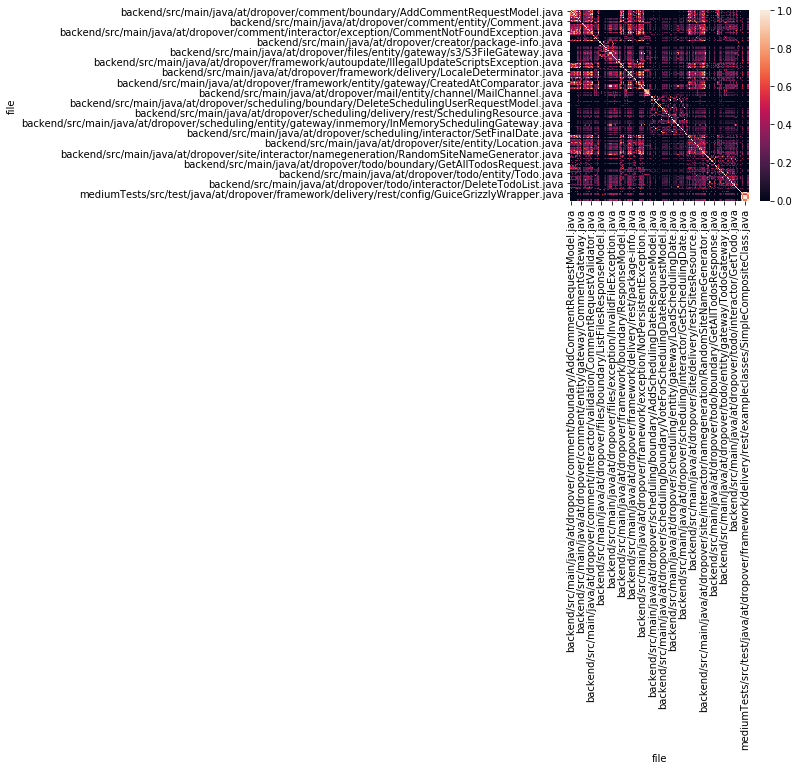

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=[4,3.5])
sns.heatmap(
    1-dissimilarity_df
)

In [80]:
domain_df = dissimilarity_df.copy()
domain_df.index = domain_df.index.str.split("/").str[6]
domain_df.columns = domain_df.index
domain_df = domain_df.sort_index()
domain_df = domain_df.sort_index(axis=1)
domain_df.head()

file,comment,comment,comment,comment,comment,comment,comment,comment,comment,comment,...,todo,todo,todo,todo,todo,todo,todo,todo,todo,todo
file,,,,,,,,,,,,,,,,,,,,,
comment,0.000000,0.500000,0.292893,0.292893,0.646447,0.591752,0.683772,0.750000,0.732739,0.764298,...,0.811018,1.000000,1.000000,0.776393,1.000000,1.0,1.000000,1.0,1.000000,1.0
comment,0.500000,0.000000,0.292893,0.292893,0.646447,0.183503,0.367544,0.500000,0.465478,0.528595,...,0.622036,0.646447,0.711325,0.552786,1.000000,1.0,0.764298,1.0,0.711325,1.0
comment,0.292893,0.292893,0.000000,0.500000,0.750000,0.422650,0.552786,0.646447,0.622036,0.666667,...,0.732739,0.750000,0.795876,0.683772,1.000000,1.0,0.833333,1.0,0.795876,1.0
comment,0.292893,0.292893,0.500000,0.000000,0.500000,0.422650,0.552786,0.646447,0.622036,0.666667,...,0.732739,1.000000,1.000000,0.683772,1.000000,1.0,1.000000,1.0,1.000000,1.0
comment,0.646447,0.646447,0.750000,0.500000,0.000000,0.711325,0.552786,0.646447,0.622036,0.666667,...,0.866369,1.000000,1.000000,0.841886,0.776393,1.0,0.833333,1.0,1.000000,1.0


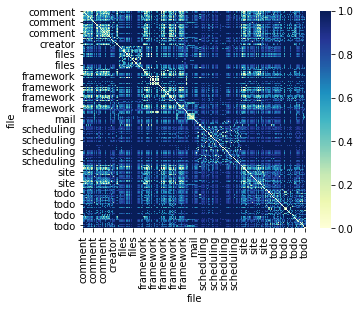

In [81]:
plt.figure(figsize=[5,4])
sns.heatmap(
    domain_df,
    #xticklabels=False,
    #yticklabels=False
    cmap="YlGnBu"
)

In [82]:
#similarity_2d_df = pd.DataFrame(similarity_2d, index=similarity_df.index)
#
#similarity_2d_df['domain'] = "Other"
#
#domains = ["Owner", "Pet", "Visit", "Vet", "Specialty", "Clinic"]
#for domain in domains:
#    similarity_2d_df.loc[similarity_2d_df.index.str.contains(domain), 'domain'] = domain
#
#similarity_2d_df.head()

In [83]:
from sklearn.manifold import MDS

# uses a fixed seed for random_state for reproducibility
model = MDS(dissimilarity='precomputed', random_state=0)
# this could take some seconds
dissimilarity_2d = model.fit_transform(dissimilarity_df)
dissimilarity_2d[:5]

array([[ 0.22923508, -0.62731066],
       [ 0.31324523, -0.4812986 ],
       [ 0.34524429, -0.43924546],
       [ 0.09319402, -0.62251441],
       [ 0.17714024, -0.56055599]])

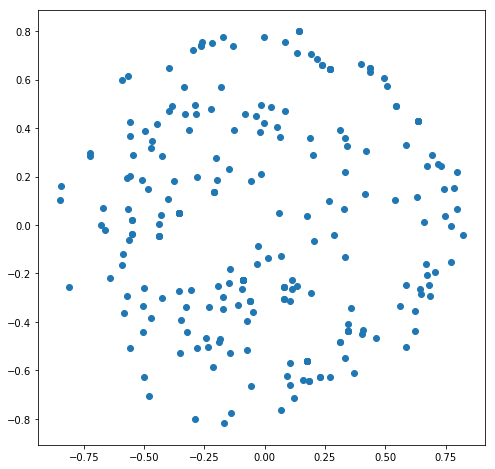

In [84]:
%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt

# brew some colors
#relative_index = distance_df.index.labels[0].values() / distance_df.index.labels[0].max()
#colors = [x for x in cm.hsv(relative_index)]

# plot the 2D matrix with colors
plt.figure(figsize=(8,8))
x = dissimilarity_2d[:,0]
y = dissimilarity_2d[:,1]
#plt.scatter(x, y, c=colors)
plt.scatter(x, y)

In [85]:
dissimilarity_2d_df = pd.DataFrame(dissimilarity_2d, index=commit_matrix.index)
dissimilarity_2d_df.head()

,0,1
file,,
backend/src/main/java/at/dropover/comment/boundary/AddCommentRequestModel.java,0.229235,-0.627311
backend/src/main/java/at/dropover/comment/boundary/ChangeCommentRequestModel.java,0.313245,-0.481299
backend/src/main/java/at/dropover/comment/boundary/CommentData.java,0.345244,-0.439245
backend/src/main/java/at/dropover/comment/boundary/GetCommentRequestModel.java,0.093194,-0.622514
backend/src/main/java/at/dropover/comment/boundary/GetCommentResponseModel.java,0.177140,-0.560556


In [86]:
#dissimilarity_2d_df['grouping'] = dissimilarity_2d_df.index.str.rsplit(".").str[-1]
dissimilarity_2d_df['grouping'] = dissimilarity_2d_df.index.str.split("/").str[6]
#dissimilarity_2d_df.loc[dissimilarity_2d_df['language'].str.strip().str.len() == 0, "language"] = "n/a"
dissimilarity_2d_df.head()

,0,1,grouping
file,,,
backend/src/main/java/at/dropover/comment/boundary/AddCommentRequestModel.java,0.229235,-0.627311,comment
backend/src/main/java/at/dropover/comment/boundary/ChangeCommentRequestModel.java,0.313245,-0.481299,comment
backend/src/main/java/at/dropover/comment/boundary/CommentData.java,0.345244,-0.439245,comment
backend/src/main/java/at/dropover/comment/boundary/GetCommentRequestModel.java,0.093194,-0.622514,comment
backend/src/main/java/at/dropover/comment/boundary/GetCommentResponseModel.java,0.177140,-0.560556,comment


In [87]:
counts = dissimilarity_2d_df.language.value_counts() 
counts = counts[counts > 10]
counts.head()

AttributeError: 'DataFrame' object has no attribute 'language'

In [ ]:
dissimilarity_2d_df.loc[
    ~dissimilarity_2d_df.language.isin(counts.index), 'language'] = "Other"
dissimilarity_2d_df['language'].value_counts()

In [ ]:
plot_data = pd.DataFrame(index=dissimilarity_2d_df['language'])
plot_data['value'] = tuple(zip(dissimilarity_2d_df[0], dissimilarity_2d_df[1]))
plot_data['label'] = dissimilarity_2d_df.index
plot_data['data'] = plot_data[['label', 'value']].to_dict('records')
plot_dict = plot_data.groupby(plot_data.index).data.apply(list)
plot_dict

In [ ]:
import pygal
xy_chart = pygal.XY(stroke=False)

for entry in plot_dict.iteritems():
    xy_chart.add(entry[0], entry[1])
xy_chart.render_in_browser()

In [ ]:
from sklearn.manifold import TSNE

# hier auf 5 lassen
model = TSNE()
# this could take some seconds
dissimilarity_2d = model.fit_transform(dissimilarity_df)
dissimilarity_2d[:5]

%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt

# brew some colors
#relative_index = distance_df.index.labels[0].values() / distance_df.index.labels[0].max()
#colors = [x for x in cm.hsv(relative_index)]

# plot the 2D matrix with colors
plt.figure(figsize=(8,8))
x = dissimilarity_2d[:,0]
y = dissimilarity_2d[:,1]
#plt.scatter(x, y, c=colors)
plt.scatter(x, y)

In [ ]:
dissimilarity_2d_df = pd.DataFrame(dissimilarity_2d, index=commit_matrix.index)
dissimilarity_2d_df['language'] = dissimilarity_2d_df.index.str.rsplit(".").str[-1]
counts = dissimilarity_2d_df.language.value_counts() 
counts = counts[counts > 10]
dissimilarity_2d_df.loc[~dissimilarity_2d_df.language.isin(counts.index), 'language'] = "Other"
plot_data = pd.DataFrame(index=dissimilarity_2d_df['language'])
plot_data['value'] = tuple(zip(dissimilarity_2d_df[0], dissimilarity_2d_df[1]))
plot_data['label'] = dissimilarity_2d_df.index
plot_data['data'] = plot_data[['label', 'value']].to_dict('records')
plot_dict = plot_data.groupby(plot_data.index).data.apply(list)
xy_chart = pygal.XY(stroke=False)

for entry in plot_dict.iteritems():
    xy_chart.add(entry[0], entry[1])
xy_chart.render_in_browser()

In [ ]:
domains_encoded = pd.factorize(domain_df.index)[0]
domains_encoded[:10]

In [ ]:
relative_index = domains_encoded / domains_encoded.max()
colors = [x for x in cm.hsv(relative_index)]
colors[:3]

In [ ]:
plt.figure(figsize=(8,8))
x = dissimilarity_2d[:,0]
y = dissimilarity_2d[:,1]
plt.scatter(x, y, c=colors)

In [ ]:
dissimilarity_2d_df['domain'] = "other"
#dissimilarity_2d_df['domain'] = dissimilarity_2d_df.index.str.split("/").str[6]
dissimilarity_2d_df.head()

In [ ]:
dissimilarity_2d_df = pd.DataFrame(dissimilarity_2d, index=commit_matrix.index)
plot_data = pd.DataFrame(index=dissimilarity_2d_df['domain'])
plot_data['value'] = tuple(zip(dissimilarity_2d_df[0], dissimilarity_2d_df[1]))
plot_data['label'] = dissimilarity_2d_df.index
plot_data['data'] = plot_data[['label', 'value']].to_dict('records')
plot_dict = plot_data.groupby(plot_data.index).data.apply(list)
plot_dict

import pygal
xy_chart = pygal.XY(stroke=False)


for entry in plot_dict.iteritems():
    xy_chart.add(entry[0], entry[1])
xy_chart.render_in_browser()

In [ ]:
import pygal
xy_chart = pygal.XY(stroke=False)


for entry in plot_dict.iteritems():
    xy_chart.add(entry[0], entry[1])
xy_chart.render_in_browser()

In [ ]:
import pygal
xy_chart = pygal.XY(stroke=False)
xy_chart.add()

In [ ]:
import pygal
xy_chart = pygal.XY(stroke=False)
xy_chart.title = 'Grouped co-changing code'
xy_chart.add('A', [{'value': (2,2), 'label': 'two'}, (4,3)])
xy_chart.render_in_browser()